Til neste gang: mer analyse av dataen, "forstå dataen". Gjøre analyser slik at leser av dokumentet forstår hva vi gjør og hvorfor vi gjør det.

In [98]:
# These have to be installed through running "pip install -r requirements.txt"

import re # for regular expressions
import numpy as np # for numerical computation
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for plotting
import sklearn  # machine learning library
import nltk # natural language toolkit

from nltk.corpus import stopwords # to remove stopwords
from nltk.tokenize import word_tokenize # to tokenize
from nltk.stem import WordNetLemmatizer # to lemmatize
from nltk.sentiment.vader import SentimentIntensityAnalyzer # to analyze sentiment

from wordcloud import WordCloud # to visualize text
from PIL import Image # to load images

from gensim.test.utils import common_texts  # some example texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument  # doc2vec model

from sklearn.feature_extraction.text import TfidfVectorizer # to convert text to numbers 
from sklearn.ensemble import RandomForestClassifier # to build a model
from sklearn.linear_model import LogisticRegression # to build a model
from sklearn.neighbors import KNeighborsClassifier # to build a model
from sklearn.model_selection import train_test_split # to split the data
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix  # to evaluate the model
from sklearn.metrics import classification_report # to evaluate the model

In [99]:
# Storing the csv file as a pandas dataframe and sample 50/50 of the positive and negative scores
df = pd.read_csv('Hotel_Reviews.csv')

positive_reviews = df[df['Reviewer_Score'] > 7]
negative_reviews = df[df['Reviewer_Score'] < 7]

negative_sample = negative_reviews.sample(n=5000, random_state=42)
positive_sample = positive_reviews.sample(n=5000, random_state=42)

balanced_df = pd.concat([positive_sample, negative_sample])
df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(balanced_df['Reviewer_Score'].apply(lambda x: 'positive' if x > 7 else 'negative').value_counts())

Reviewer_Score
positive    5000
negative    5000
Name: count, dtype: int64


In [100]:
def replace(cell): 
    if cell == "No Positive" or cell == "No Negative":
        return ""
    return cell

df['Negative_Review'] = df['Negative_Review'].apply(replace)
df['Positive_Review'] = df["Positive_Review"].apply(replace)

In [101]:

def combine_names(row):
    return f"{row['Positive_Review']} {row['Negative_Review']}"


df["Review"] = df.apply(combine_names, axis="columns")

In [102]:
df = df.drop(["Hotel_Address", "Additional_Number_of_Scoring", "Review_Date", "Average_Score", "Reviewer_Nationality", "Review_Total_Negative_Word_Counts", "Review_Total_Positive_Word_Counts", "Total_Number_of_Reviews_Reviewer_Has_Given", "Tags", "days_since_review", "lat", "lng", "Hotel_Name", "Total_Number_of_Reviews", "Negative_Review", "Positive_Review"], axis = "columns")
df

,Reviewer_Score,Review
0,2.9,when it was time to leave The hot and cold a...
1,7.5,The staff are excellent Had to move at 0130 d...
2,9.6,General ambiance very good Great position geo...
3,10.0,Amazing place great location just 150mt from ...
4,8.8,Location
...,...,...
9995,6.7,clean and nice I reserve this hotel for my ...
9996,6.7,The ambience poor facilities
9997,2.5,Construction work and drilling all day Manag...
9998,10.0,The facility is luxurious and a good location...


In [103]:

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the preprocessing function
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    
    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Join the tokens back into a single string
    processed_text = ' '.join(lemmatized_tokens)
    
    return processed_text

# Apply the preprocessing function to your DataFrame
df['Review'] = df['Review'].apply(preprocess_text)

In [104]:
# Sentiment analysis

analyzer = SentimentIntensityAnalyzer()

# Returns a 1 if analyzers recognizes it as positive and 0 if not
def sentiment(text):
    result = analyzer.polarity_scores(text)
    sentiment = 1 if result["pos"] > 0 else 0
    return sentiment

#This function will return a more detailed sentiment analyze with float numbers
def sentiment_detailed(text):
    result = analyzer.polarity_scores(text)
    return result

df["Sentiment"] = df['Review'].apply(sentiment)
df["Sentiments"] = df["Review"].apply(sentiment_detailed)
df = pd.concat([df.drop(['Sentiments'], axis=1), df['Sentiments'].apply(pd.Series)], axis=1)

df

#https://medium.com/@amalia.wulandiari/sentiment-analysis-hotel-review-python-nltk-846738de727f

,Reviewer_Score,Review,Sentiment,neg,neu,pos,compound
0,2.9,time leave hot cold alternating temperature no...,0,0.243,0.757,0.000,-0.5849
1,7.5,staff excellent move 0130 due noise faulty air...,1,0.124,0.522,0.355,0.9382
2,9.6,general ambiance good great position geographi...,1,0.000,0.341,0.659,0.9260
3,10.0,amazing place great location 150mt goodge stre...,1,0.061,0.277,0.662,0.9709
4,8.8,location,0,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...
9995,6.7,clean nice reserve hotel aunty booking com sho...,1,0.072,0.692,0.236,0.6908
9996,6.7,ambience poor facility,0,0.608,0.392,0.000,-0.4767
9997,2.5,construction work drilling day manager rood be...,0,0.000,1.000,0.000,0.0000
9998,10.0,facility luxurious good location swimming pool,1,0.000,0.633,0.367,0.4404


In [105]:
# Create TaggedDocument objects
docs = [TaggedDocument(doc.split(' '), [i]) for i, doc in enumerate(df['Review'])]

# Train the Doc2Vec model
model = Doc2Vec(docs, vector_size=5, window=2, min_count=1, workers=4)

# Infer vectors for each document
doc2vec_vectors = df['Review'].apply(lambda x: model.infer_vector(x.split(' ')))

# Convert the list of vectors into a DataFrame
doc2vec_df = pd.DataFrame(doc2vec_vectors.tolist())

# Add column names
doc2vec_df.columns = ['doc2vec_vector_' + str(i) for i in range(doc2vec_df.shape[1])]

# Concatenate with the original DataFrame
df = pd.concat([df, doc2vec_df], axis=1)

# Display the final DataFrame
df

,Reviewer_Score,Review,Sentiment,neg,neu,pos,compound,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,2.9,time leave hot cold alternating temperature no...,0,0.243,0.757,0.000,-0.5849,0.103454,0.286361,0.230278,0.014557,0.083946
1,7.5,staff excellent move 0130 due noise faulty air...,1,0.124,0.522,0.355,0.9382,0.268074,0.431429,0.203361,0.259469,-0.279125
2,9.6,general ambiance good great position geographi...,1,0.000,0.341,0.659,0.9260,0.086971,0.062203,0.168948,-0.184167,0.126973
3,10.0,amazing place great location 150mt goodge stre...,1,0.061,0.277,0.662,0.9709,0.110954,-0.112448,0.178767,-0.161070,-0.148340
4,8.8,location,0,0.000,1.000,0.000,0.0000,-0.003641,0.062507,0.107753,-0.056723,0.021105
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,6.7,clean nice reserve hotel aunty booking com sho...,1,0.072,0.692,0.236,0.6908,0.274387,0.270378,0.765856,0.179606,-0.177986
9996,6.7,ambience poor facility,0,0.608,0.392,0.000,-0.4767,0.095934,-0.006732,0.089816,-0.069450,-0.066731
9997,2.5,construction work drilling day manager rood be...,0,0.000,1.000,0.000,0.0000,0.230766,-0.011041,0.216430,0.051681,-0.153869
9998,10.0,facility luxurious good location swimming pool,1,0.000,0.633,0.367,0.4404,-0.038165,0.075756,0.123437,-0.105346,-0.100600


In [106]:
# Adding TF-IDF values to find out the importance of words in the reviews
tfidf = TfidfVectorizer(min_df = 10) # Initialize the TfidfVectorizer with a minimum document frequency of 10
tfidf_result = tfidf.fit_transform(df['Review']).toarray() # Fit and transform the 'Review' column to compute TF-IDF values
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())# Convert the TF-IDF matrix into a DataFrame
tfidf_df.columns = ['word_' + str(x) for x in tfidf_df.columns] # Rename columns to avoid conflicts with existing column names
tfidf_df.index = df.index # Align the index of the TF-IDF DataFrame with the original DataFrame
df = pd.concat([df, tfidf_df], axis=1) # Concatenate the original DataFrame with the TF-IDF DataFrame
df.head()

,Reviewer_Score,Review,Sentiment,neg,neu,pos,compound,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,...,word_would,word_wow,word_written,word_wrong,word_yard,word_year,word_yes,word_yet,word_young,word_zero
0,2.9,time leave hot cold alternating temperature no...,0,0.243,0.757,0.000,-0.5849,0.103454,0.286361,0.230278,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,7.5,staff excellent move 0130 due noise faulty air...,1,0.124,0.522,0.355,0.9382,0.268074,0.431429,0.203361,...,0.0,0.0,0.0,0.0,0.0,0.144989,0.0,0.0,0.0,0.0
2,9.6,general ambiance good great position geographi...,1,0.000,0.341,0.659,0.9260,0.086971,0.062203,0.168948,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,10.0,amazing place great location 150mt goodge stre...,1,0.061,0.277,0.662,0.9709,0.110954,-0.112448,0.178767,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,8.8,location,0,0.000,1.000,0.000,0.0000,-0.003641,0.062507,0.107753,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [107]:
# Add a column for y, which gives the review either positive or negative
df['posneg'] = df['Reviewer_Score'].apply(lambda x: 0 if x < 7 else 1)

In [108]:
# Calculate Positive and Negative Reviews
train_pos = df[ df['posneg'] == 1]
train_pos = train_pos['Review']
train_neg = df[ df['posneg'] == 0]
train_neg = train_neg['Review']

In [109]:
# Generate WordCloud function for negative and positive reviews
# source: https://medium.com/@amalia.wulandiari/sentiment-analysis-hotel-review-python-nltk-846738de727f

def wordCloud_generator(data, color, color_map):

    
    wordcloud = WordCloud(width = 1000, height = 1000,
                          background_color =color,
                          min_font_size = 12,
                          colormap= color_map,
                         ).generate(' '.join(data.values))
    
    # plot the WordCloud image                        
    plt.figure(figsize = (7, 10), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis('off')
    
    plt.show() 

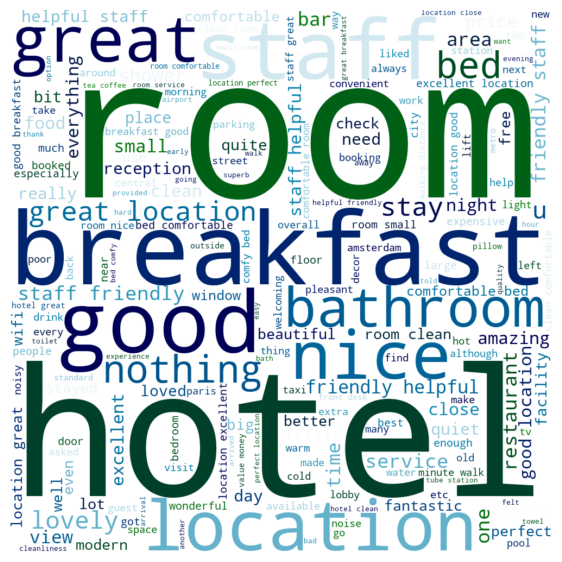

In [110]:
# WordCloud for Positive Review

wordCloud_generator(train_pos, 'white', 'ocean')

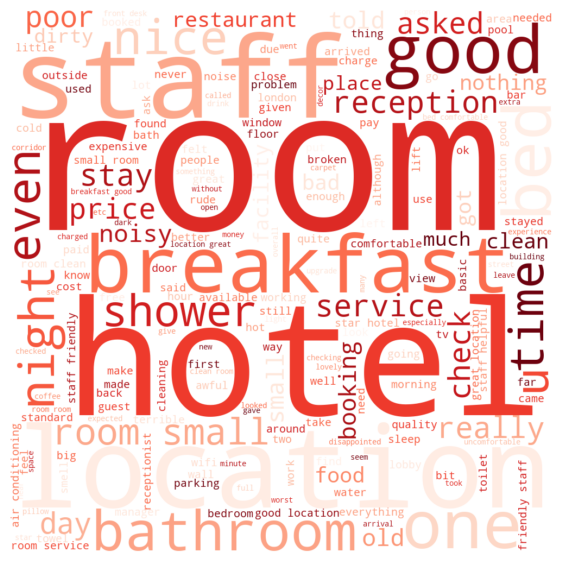

In [111]:
# WordCloud for Positive Review

wordCloud_generator(train_neg, 'white', 'Reds')

In [112]:
# Remove review before using the models
df = df.drop(['Review'], axis=1)

In [113]:
x = df.drop(['posneg', 'Reviewer_Score'], axis=1)
y = df['posneg']


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [ ]:
# Random Forest Classifier
rfmodel = RandomForestClassifier(random_state=42)
rfmodel.fit(X_train, y_train)
prediction = rfmodel.predict(X_test)

classification_decision1 = (classification_report(y_test, rfmodel.predict(X_test)))
print("Random Forest Classifier")
print(classification_decision1)

Random Forest Classifier
              precision    recall  f1-score   support

           0       0.77      0.78      0.77      1228
           1       0.78      0.77      0.78      1272

    accuracy                           0.78      2500
   macro avg       0.78      0.78      0.78      2500
weighted avg       0.78      0.78      0.78      2500



In [ ]:
# Logistic Regression
lrmodel = LogisticRegression(random_state=42, max_iter=300)
lrmodel.fit(X_train, y_train)
pred_lr = lrmodel.predict(X_test)

print("Logistic Regression")
print(classification_report(y_test, pred_lr))

Logistic Regression
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1228
           1       0.80      0.81      0.80      1272

    accuracy                           0.80      2500
   macro avg       0.80      0.80      0.80      2500
weighted avg       0.80      0.80      0.80      2500



In [ ]:
# KNN
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train)
pred_knn = knn_model.predict(X_test)

print("KNN")
print(classification_report(y_test, pred_knn))

KNN
              precision    recall  f1-score   support

           0       0.79      0.62      0.69      1228
           1       0.70      0.84      0.76      1272

    accuracy                           0.73      2500
   macro avg       0.74      0.73      0.73      2500
weighted avg       0.74      0.73      0.73      2500

